# 1. Setup

## 1.1. Importing and installing the necessary libraries


In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install rouge_score

In [ ]:
# Importing necessary librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import io
import pickle 
import datasets
from datasets import load_metric
import seaborn as sns
import tensorflow as tf
import torch
from transformers import BertTokenizer
import keras
from keras import layers
from keras import backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from google.colab import drive


## 1.2. Importing personal drive to file in order to later load the data and the saved fine tuned model

In [ ]:
# Mount Google Drive to this Notebook instance.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.3. Setting the GPU for training the model 


In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 2. Load and Format data

In [ ]:
# We load the cleaned data from a pickle format
file ='/content/drive/MyDrive/Colab Notebooks/Data/final_clean.pickle'
df = pd.read_pickle(file)

In [ ]:
# Looking at the data
df

,description_narrative,TLDR,text_clean,text_embedding,summary_clean,summary_embedding,labels,labels_idx_list,doc_label
0,The training improved women’s knowledge on the...,The training improved women’s knowledge on the...,[The training improved women’s knowledge on th...,"[[0.76747984, -0.1894493, 0.51285785, -0.02116...",[The training improved women’s knowledge on th...,"[[0.76747984, -0.1894493, 0.51285785, -0.02116...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Illegal oil refining in the Niger Delta is inc...,CEHRD in an effort to create awareness on the ...,[Illegal oil refining in the Niger Delta is in...,"[[-0.26888534, -0.6092957, -0.23817927, -1.167...",[CEHRD in an effort to create awareness on the...,"[[-0.43648192, -0.071132354, -0.18081759, -0.4...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 3]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,CEHRD successfully set-up 4 formal and 4 infor...,CEHRD set-up the environmental clubs with the ...,[CEHRD successfully set-up 4 formal and 4 info...,"[[-0.48964322, -1.2085572, 1.0374501, 0.021369...",[CEHRD set-up the environmental clubs with the...,"[[-0.15335692, -0.29430717, 0.58692193, -1.126...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[10],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
3,PROJECT NAME : Delivering Accelerated Family P...,Delivering Accelerated Family Planning in Paki...,"[PROJECT NAME :, Delivering Accelerated Family...","[[-0.23698506, 0.15983863, -0.071198896, -1.20...",[Delivering Accelerated Family Planning in Pak...,"[[-0.50266284, -1.2923895, 0.4206834, -1.25673...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[1],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,Road traffic injuries are world's eighth leadi...,The Cardiff Trauma Pack Research and Develop...,[Road traffic injuries are world's eighth lead...,"[[-0.4666822, -1.19177, 0.9945381, -0.95759714...",[ The Cardiff Trauma Pack Research and Develo...,"[[-0.4679708, -0.43502182, 0.8388376, -1.47547...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[4, 5]","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
...,...,...,...,...,...,...,...,...,...
2980,Metta has been responding to the humanitarian ...,"ProjectGoal: To improve the condition of 2,854...",[Metta has been responding to the humanitarian...,"[[-0.6875755, -1.0828758, 0.32236806, -1.33987...","[ProjectGoal:, To improve the condition of 2,8...","[[-0.58209735, 0.027911462, 0.29285246, -1.098...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[7, 8]","[2980, 2980, 2980, 2980, 2980, 2980, 2980, 298..."
2981,"Destined Women is local not for profit, non-re...",GOAL: Contribute towards changing the socioeco...,"[Destined Women is local not for profit, non-r...","[[-0.3787009, -0.7928037, 0.16012278, -0.16681...","[GOAL:, Contribute towards changing the socioe...","[[-0.2746246, 0.04018628, 0.4832729, -0.996766...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1, 7]","[2981, 2981, 2981, 2981, 2981, 2981, 2981, 298..."
2982,The project will empower secondary school stud...,The project will empower secondary school stud...,[The project will empower secondary school stu...,"[[0.3152278, -0.62204534, 1.0845532, -0.392865...",[The project will empower secondary school stu...,"[[0.3152278, -0.62204534, 1.0845532, -0.392865...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",[0],"[2982, 2982, 2982, 2982, 2982, 2982, 2982, 2982]"
2983,The project has been specifically designed to ...,The project has been specifically designed to ...,[The project has been specifically designed to...,"[[0.2448853, -0.043037124, 0.5578783, -0.51006...",[The project has been specifically designed to...,"[[0.2448853, -0.043037124, 0.5578783, -0.51006...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",[0],"[2983, 2983, 2983, 2983, 2983, 2983]"


## 2.2. Creating the train and test sets in the right format

### 2.2.1. Creating the train set, with each row being a sentence 

In [ ]:
# Splitting the dataframe into a train and a test set, keeping 20% for the test set. 
train_dataset, test_dataset = train_test_split(df, test_size=0.2)

# We wish to split each sentence individually for the purpose of classification. 
#for this reason, we create three empty lists to later feed them with the individual sentences, associated with their label and document label 
sentences, labels, document_labels = [], [], [] 

# We do the below to feed the empty lists
#looping through the embeddings, the document labels, the text and the target labels
for doc_x, doc_y, doc_label in zip(train_dataset['text_clean'], 
                                   train_dataset['labels'], 
                                   train_dataset['doc_label']):
                                          
#looping through each item within the text, the target labels, the document labels
    for i, (sent, target, label) in enumerate(zip(doc_x, doc_y, doc_label)):
        
        #appending each item to the empty lists previously created 
        sentences.append(sent) #this will be used to train the data points 
        labels.append(target) #this will be used to train the data points
        document_labels.append(label) #this will be used to retrieve the intial document the sentence belongs to 

# We then create a dataframe out of the created lists 
train_dataset = pd.DataFrame({'sentence': sentences,
                             'label' :  labels,
                             'document_label': document_labels,
                             })

# For precision, we convert the current float labels to integers 
#creation of an empty list
new_label = []

#looping in the label column, converting each label to an integer and appending to the new_label list
for i in train_dataset['label']:
  i = int(i)
  new_label.append(i)  

#updating the label column with the new_label list
train_dataset['label'] = new_label

# Viewing the pre-formatted train_dataset
train_dataset

,sentence,label,document_label
0,The objective of Financial Sector Development ...,1,1692
1,The project has four components.,0,1692
2,(1) Improving financial sector regulatory over...,0,1692
3,(2) Increasing the outreach of Rural and Commu...,0,1692
4,(3) Bolstering financial capability and consum...,0,1692
...,...,...,...
24774,"EI and ON#s joint project, Quality Educators f...",0,2288
24775,In-service training and teacher professional d...,0,2288
24776,The project till now only piloted at primary t...,1,2288
24777,Knowing that we aim to achievethe goal of gett...,1,2288


### 2.2.2. Creating the test set, with each row being a sentence


In [ ]:
# We repeat the same process for the test_dataset

# Creating empty lists 
sentences, labels, document_labels = [], [], [] 

#looping through the embeddings, the document labels, the text and the target labels
for doc_x, doc_y, doc_label in zip(test_dataset['text_clean'], 
                                   test_dataset['labels'], 
                                   test_dataset['doc_label']):
                                          
    #looping through each item within the text, the target labels, the document labels
    for i, (sent, target, label) in enumerate(zip(doc_x, doc_y, doc_label )):
        
        #appending each item to the empty lists previously created 
        sentences.append(sent) #this will be used to train the data points 
        labels.append(target) #this will be used to train the data points
        document_labels.append(label) #this will be used to retrieve the intial document the sentence belongs to 

# Creating a new test_dataset dataframe with appropriate lists 
test_dataset = pd.DataFrame({'sentence': sentences,
                             'label' :  labels,
                             'document_label': document_labels,
                             })

# Converting float labels to integers 
new_label = []

for i in test_dataset['label']:
  i = int(i)
  new_label.append(i)   

#updating the label column with the new_label list
test_dataset['label'] = new_label

# Viewing the pre-formatted train_dataset
test_dataset

,sentence,label,document_label
0,The objective of this project is to promote in...,1,2907
1,Many thinkers on development give high priorit...,0,2907
2,That justification is needed for good governan...,0,2907
3,Investigative journalism can play a major role...,0,2907
4,This project will contribute to greater accoun...,0,2907
...,...,...,...
6385,"Second, disbursement amounts associated with t...",0,1867
6386,The tranche associated with three prior action...,0,1867
6387,The remaining seven tranches will be released ...,0,1867
6388,Tranches will decrement in amount if fulfilmen...,0,1867


# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into BERT outputs for the LSTM to be trained on top of it to enhance our summarisation. 

## 3.1. Formatting the data



In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Now computing the longest sentence's length to later pad to that length 
#setting the max length to 0
max_len = 0

#create sentence and label lists from train dataset
sentences = train_dataset.sentence.values
labels = train_dataset.label.values

#for every sentence...
for sent in sentences:

    #tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    #update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

#printing the maximum sentence length. 
print('Max sentence length: ', max_len)

Loading BERT tokenizer...
Max sentence length:  210


Now that we have the maximum sentence length, we can pre-process all the sentences as per defined above. 

We use the encode_plus method of huggingface's BERT tokenizer to carry these steps.

## 3.2. Required Formatting

## 3.3. Tokenize Dataset

Using the encode_plus method provided by Huggingface, we tokenise the text, map each token to its input id and pad each sentence for them to match the length of the longest sequence. 

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])


# Convert the lists into numpy arrays.
input_ids = [t.numpy() for t in input_ids]
labels = np.array(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print ('Label:', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The objective of Financial Sector Development Project for Ghana is to promote financial sector soundness and access to financial services by individuals.
Token IDs: [[ 101 1996 7863 1997 3361 4753 2458 2622 2005 9701 2003 2000 5326 3361
  4753 2614 2791 1998 3229 2000 3361 2578 2011 3633 1012  102    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 

## 3.2. Training & Validation Split


In [ ]:
# We must have the input_ids in the right format for the LSTM to read accurately. 
# That is, each sentence must be one array. 
# The current format makes each input_id vector be an array of an array. 

#therefore:
#creating an empty list 
input_id = []

#looping in the first input_ids array
for ids in input_ids: 
  #looping in the final array
  for i in ids:
    #appending to the new list 
    input_id.append(i)

# Creating a train_dataset with the good input_ids format, associating the labels 
train_dataset = pd.DataFrame({'input_ids': input_id,
                             'label' :  labels,
                             })

# Splitting the train_dataset into a main train and a main development set
df_train, df_dev = train_test_split(train_dataset, test_size=0.1, random_state=42)

# Splitting each main train and development sets into an X and a y respectively 
# Converting the data from dataframes to numpy arrays
X_train, y_train = np.vstack(df_train['input_ids'].values), df_train['label'].values
X_dev, y_dev = np.vstack(df_dev['input_ids'].values), df_dev['label'].values

In [ ]:
X_train

array([[  101,  2034,  9229, ...,     0,     0,     0],
       [  101,  9779, 14227, ...,     0,     0,     0],
       [  101,  4746,  1012, ...,     0,     0,     0],
       ...,
       [  101,  1999,  5903, ...,     0,     0,     0],
       [  101,  1996,  2622, ...,     0,     0,     0],
       [  101,  2224, 17261, ...,     0,     0,     0]])

# 4. Train Our Classification Model

## 4.1. Vocabulary size

The LSTM requires an input dimension specification, which should be the size of the vocabulary. 
This is what we compute below. 

In [ ]:
# Create an empty list of all the all_ids which will later be populated with all the ids in every sentence vector. 
all_ids = []

#to do this, we loop a first time into the input_ids
for i in input_ids:
  #a second time
  for j in i: 
    #and a third time to have all individual ids 
    for c in j:
      all_ids.append(c)

# Having all the ids will help us build our vocabulary and therefore know its size
#we create an empty list which will later be populated with all the distinct input_ids representing one same word
vocab = []

#we loop into the all_ids list
for id in all_ids:
  #if the id is not in the list of vocab, we add it to the list 
  if id not in vocab:
    vocab.append(id)

#the size of the vocabulary equals to the maximum value of the vocabulary 
vocab_size = max(vocab)
print('There are {} tokens in the vocab'.format(vocab_size))

There are 29667 tokens in the vocab


## 4.2. Building a fine-tuned stacked LSTM 

Now that we have the necessary information to fine tune our LSTM, we can build the model. 

To that aim, we use the library of keras and the pretrained Sequential model 
To improve its performance, we create a stacked LSTM with 5 layers. 

Additionnally, we add a dense layer with a relu activation and we apply dropout. 
Lastly, we add a single sigmmoid activation dense layer to perform the  classification task. 

Further, we chose adam learning rate for the optimizer, a binay crossentropy loss function and a batch size of 50 for the hyperparameters.

In [ ]:
longest_sequence = 250 
embedding_size = 250

lstm_model = keras.Sequential()  # the keras Sequential class groups a linear stack of layers into a tf.keras.Model

# Add an Embedding layer expecting input vocab, and output dimenstion the size of our embeddings
lstm_model.add(layers.Embedding(input_shape=(longest_sequence,), input_dim=30200, output_dim=64, input_length=longest_sequence,
                                mask_zero=True, trainable=False))


# Create a stacked LSTM with 5 LSTM layers
lstm_model.add(layers.LSTM(256, return_sequences=True))
lstm_model.add(layers.LSTM(256, return_sequences=True))  # and another layer
lstm_model.add(layers.LSTM(128, return_sequences=True))  # and another layer
lstm_model.add(layers.LSTM(64, return_sequences=True))  # and another layer
lstm_model.add(layers.LSTM(32, return_sequences=False))  # and another layer

# Add another Dense layer (with relu activation) and apply dropout
lstm_model.add(keras.layers.Dense(32, activation='relu'))
lstm_model.add(keras.layers.Dropout(rate=0.4))  # we will drop 40% of the input units at random during training

# Add a Dense layer with a single unit and sigmoid activation.
lstm_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 64)           1932800   
_________________________________________________________________
lstm_15 (LSTM)               (None, 250, 256)          328704    
_________________________________________________________________
lstm_16 (LSTM)               (None, 250, 256)          525312    
_________________________________________________________________
lstm_17 (LSTM)               (None, 250, 128)          197120    
_________________________________________________________________
lstm_18 (LSTM)               (None, 250, 64)           49408     
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

## 4.3. Training our fine-tuned stacked LSTM

We chose to train the model on 25 epochs given the results of the 50 epochs trained LSTM models, to avoid overfitting the training data, hence increasing the ability of the model to generalise


In [ ]:
# Set the batch size.  
batch_size = 50  

# Train the model
lstm_trained = lstm_model.fit(X_train, y_train, 
                    batch_size=batch_size, epochs=25,
                    validation_data=(X_dev, y_dev))

Epoch 1/25


446/447 [============================>.] - ETA: 0s - loss: 0.3689 - accuracy: 0.8890WARNING:tensorflow:Model was constructed with shape (None, 250) for input KerasTensor(type_spec=TensorSpec(shape=(None, 250), dtype=tf.float32, name='embedding_3_input'), name='embedding_3_input', description="created by layer 'embedding_3_input'"), but it was called on an input with incompatible shape (None, 210).


447/447 [==============================] - 50s 70ms/step - loss: 0.3688 - accuracy: 0.8890 - val_loss: 0.3578 - val_accuracy: 0.8846
Epoch 2/25
447/447 [==============================] - 27s 60ms/step - loss: 0.3510 - accuracy: 0.8872 - val_loss: 0.3550 - val_accuracy: 0.8846
Epoch 3/25
447/447 [==============================] - 26s 59ms/step - loss: 0.3297 - accuracy: 0.8937 - val_loss: 0.3237 - val_accuracy: 0.8870
Epoch 4/25
447/447 [==============================] - 26s 59ms/step - loss: 0.3039 - accuracy: 0.8953 - val_loss: 0.3014 - val_accuracy: 0.8846
Epoch 5/25
447/447 [==============================] - 27s 60ms/step - loss: 0.2864 - accuracy: 0.9024 - val_loss: 0.2944 - val_accuracy: 0.9088
Epoch 6/25
447/447 [==============================] - 27s 61ms/step - loss: 0.2786 - accuracy: 0.9133 - val_loss: 0.2863 - val_accuracy: 0.9072
Epoch 7/25
447/447 [==============================] - 26s 57ms/step - loss: 0.2743 - accuracy: 0.9180 - val_loss: 0.2829 - val_accuracy: 0.9140
Epo

In [ ]:
#Saving the model
#lstm_model.save('/content/drive/MyDrive/Colab Notebooks/LSTM_fined_tuned_25_epochs_final')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/LSTM_fined_tuned_25_epochs_final/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/LSTM_fined_tuned_25_epochs_final/assets


In [ ]:
#Loading the model 
#lstm_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LSTM_fined_tuned_25_epochs_final')

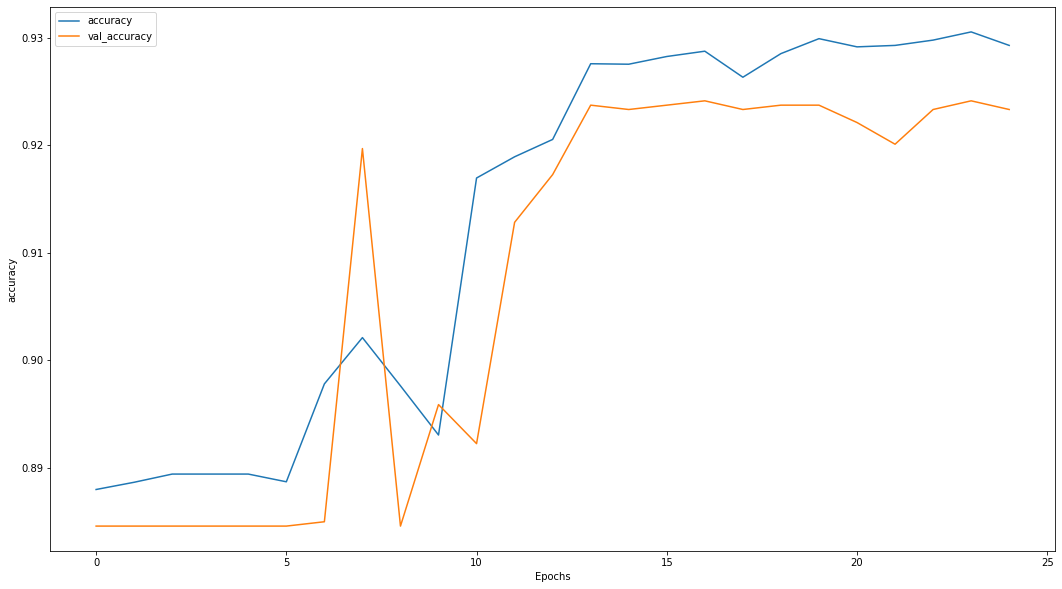

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 10)  # set default figure size

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

    
plot_graphs(lstm_trained, 'accuracy')

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
# Now computing the longest sentence's length to later pad to that length 
#setting the max length to 0
max_len = 0

#create sentence and label lists from train dataset
sentences = test_dataset.sentence.values
labels = test_dataset.label.values

#for every sentence...
for sent in sentences:

    #tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    #update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

#printing the maximum sentence length. 
print('Max sentence length: ', max_len)

Max sentence length:  203


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])


# Convert the lists into numpy arrays.
input_ids = [t.numpy() for t in input_ids]
labels = np.array(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print ('Label:', labels[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The objective of this project is to promote investigative journalism stories, with and through Africa's cooperation with Dutch journalists.
Token IDs: [[  101  1996  7863  1997  2023  2622  2003  2000  5326 15025  8083  3441
   1010  2007  1998  2083  3088  1005  1055  6792  2007  3803  8845  1012
    102     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     

In [ ]:
# We must have the input_ids in the right format for the LSTM to read accurately. 
# That is, each sentence must be one array. 
# The current format makes each input_id vector be an array of an array. 

#therefore:
#creating an empty list b
input_id = []

#looping in the first input_ids array
for ids in input_ids: 
  #looping in the final array
  for i in ids:
    #appending to the new list 
    input_id.append(i)

#
document_labels = test_dataset['document_label']

# Creating a test_dataset with the good input_ids format, associating the labels 
test_dataset = pd.DataFrame({'input_ids': input_id,
                             'label' :  labels,
                             'document_label' : document_labels,
                             'sentence' : sentences
                             })

# Splitting the test set into an X and a y respectively 
# Converting the data from dataframes to numpy arrays
X_test, y_test = np.vstack(test_dataset['input_ids'].values), test_dataset['label'].values

In [ ]:
def predict_summary(X, threshold=0.5):
    probabilities = lstm_model.predict(X)
    predictions = [1 if prob >= threshold else 0 for prob in probabilities]
    return predictions

In [ ]:
# Show predictions on the dev set
test_dataset_predict = test_dataset.copy()
test_dataset_predict['prediction'] = predict_summary(X_test)
test_dataset_predict

,input_ids,label,document_label,sentence,prediction
0,"[101, 1996, 7863, 1997, 2023, 2622, 2003, 2000...",1,2907,The objective of this project is to promote in...,0
1,"[101, 2116, 24762, 2006, 2458, 2507, 2152, 947...",0,2907,Many thinkers on development give high priorit...,0
2,"[101, 2008, 19777, 2003, 2734, 2005, 2204, 106...",0,2907,That justification is needed for good governan...,0
3,"[101, 15025, 8083, 2064, 2377, 1037, 2350, 253...",0,2907,Investigative journalism can play a major role...,0
4,"[101, 2023, 2622, 2097, 9002, 2000, 3618, 1784...",0,2907,This project will contribute to greater accoun...,0
...,...,...,...,...,...
6385,"[101, 2117, 1010, 4487, 19022, 28393, 3672, 83...",0,1867,"Second, disbursement amounts associated with t...",0
6386,"[101, 1996, 25283, 5403, 3378, 2007, 2093, 318...",0,1867,The tranche associated with three prior action...,0
6387,"[101, 1996, 3588, 2698, 25283, 8376, 2097, 202...",0,1867,The remaining seven tranches will be released ...,0
6388,"[101, 25283, 8376, 2097, 11703, 28578, 4765, 1...",0,1867,Tranches will decrement in amount if fulfilmen...,0


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Create a new dataframe which groups the predictions based on their document_label to map the prediction to the original text 
df_summaries = test_dataset_predict.groupby('document_label').agg(list)
#resetting the index
df_summaries = df_summaries.reset_index()

# Now we wish to extract the summaries only 
# Keeping the sentences that were predicted with 1
#creating empty lists
predicted_labels, predicted_sentences, actual_labels, actual_sentences, doc_labels =[],[],[],[],[]

#looping in every line of the df_summaries simultaneously 
for predicted_label, predicted_text, actual_label, doc_label in zip(df_summaries['prediction'], 
                                                                    df_summaries['sentence'], 
                                                                    df_summaries['label'], 
                                                                    df_summaries['document_label']):
    #looping in each item of each line of df_summaries
    for pred_label, pred_sent, act_label in zip(predicted_label, 
                                                              predicted_text, 
                                                              actual_label):
        #setting the condition that only if the item equals 1 in the predicted_labels
        #assing the text, the predicted label, the actual label and the document label to the lists 
        if pred_label == 1:
            predicted_labels.append(pred_label)
            predicted_sentences.append(pred_sent)
            actual_labels.append(act_label)
            doc_labels.append(doc_label)

# Creating a new dataframe with only the predicted sentences kept, against the actual label 
df_summaries = pd.DataFrame({'predicted_label': predicted_labels,
                             'predicted_summary': predicted_sentences,
                             'reference_label' : actual_labels,
                             'document_label': doc_labels})

#grouping by the document label and resetting the index 
df_summaries = df_summaries.groupby('document_label').agg(list).reset_index()

# Adding the actual summaries for each document to the dataframe
# This is critical for the evaluation 

#creataing an empty list 
actual_summaries = []

#looping though the document labels in the df_summaries 
for label in df_summaries['document_label']:
  #looping through both the indexes and the text of the original summaries in the initial dataframe
  for index, summ in zip(df.index, df['summary_clean']):
        #setting the condition that if the index of the actual summary in the original document equals 
        #to the label of the document in the results (i.e. summaries) dataframe 
        #append the summary to the empty list
        if label == index:
            actual_summaries.append(summ)

# Adding the list to the df_summaries dataframe
df_summaries['reference_summary'] = actual_summaries



### 5.3.2. Computing ROUGE scores

In [ ]:
# Computing rouge scores for the results 

#load Huggingface's rouge metric 
metric = load_metric("rouge")

#creating empty lists for the predicted and the actual summaries 
predicted_summ = []
reference_summ = []

#looping through both the predicted and the actual summaries 
for doc_pred, doc_label in zip(df_summaries['predicted_summary'], df_summaries['reference_summary']):
    #looping through each sentence within the predicted and the actual summaries  
    for pred_summ, labelled_summ in zip(doc_pred, doc_label):
        #appending these to the empty lists 
        predicted_summ.append(pred_summ)
        reference_summ.append(labelled_summ)

#computing and saving the rouge scores in rouge_scores object 
rouge_scores = metric.compute(predictions=predicted_summ, references=reference_summ)

#printing the scores 
print(rouge_scores)

{'rouge1': AggregateScore(low=Score(precision=0.9257851472368479, recall=0.9357881701962769, fmeasure=0.9272358261551663), mid=Score(precision=0.9479315062834128, recall=0.95643105805796, fmeasure=0.9492155914099775), high=Score(precision=0.9682839125664545, recall=0.9749848594184096, fmeasure=0.9690424080918864)), 'rouge2': AggregateScore(low=Score(precision=0.9059267137821737, recall=0.915025174876214, fmeasure=0.907757401757518), mid=Score(precision=0.9369614074766544, recall=0.9439622771080523, fmeasure=0.9382879119866974), high=Score(precision=0.960691612960206, recall=0.9677936929779334, fmeasure=0.9620564675796548)), 'rougeL': AggregateScore(low=Score(precision=0.9235862489128728, recall=0.9323720122976309, fmeasure=0.9245775905062823), mid=Score(precision=0.946366994300682, recall=0.95489861230747, fmeasure=0.947669961382104), high=Score(precision=0.9681146296652332, recall=0.9743828656403412, fmeasure=0.9690237390714418)), 'rougeLsum': AggregateScore(low=Score(precision=0.9220

In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][2])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][2])

This is the reference summary: 
['The project aims to improve water supply and sanitation in Nkhata Bay Town']
This is the predicted summary: 
['The objective of the project is to contribute to the economic development of the country by improving the health and livelihoods of the residents of Nkhata Bay Town and its surrounding areas.']


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][5])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][5])

This is the reference summary: 
['The objective of the project is to reduce the vulnerability of coastal communities to the impact of climate-change inudced risks in four upazilas in coastal districts of Bangladesh.']
This is the predicted summary: 
['The objective of the project is to reduce the vulnerability of coastal communities to the impact of climate-change inudced risks in four upazilas in coastal districts of Bangladesh.']


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][243])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][243])

This is the reference summary: 
['The objective of the Trans-Hindukush Road Connectivity Project for Afghanistan is to improve road transport connectivity across the Hindukush mountain range.']
This is the predicted summary: 
['The objective of the Trans-Hindukush Road Connectivity Project for Afghanistan is to improve road transport connectivity across the Hindukush mountain range.']


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][103])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][103])

This is the reference summary: 
['The development objectives of Transport Sector Development Project for Cameroon are to: (a) strengthen transport planning; (b) improve transport efficiency and safety on the Babadjou-Bamenda section of the Yaounde - Bamenda transport corridor; and (c) enhance safety and security at selected airports.']
This is the predicted summary: 
['The development objectives of Transport Sector Development Project for Cameroon are to: (a) strengthen transport planning; (b) improve transport efficiency and safety on the Babadjou-Bamenda section of the Yaounde - Bamenda transport corridor; and (c) enhance safety and security at selected airports.']


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][109])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][109])

This is the reference summary: 
["The objectives of the Additional Financing for the Taiz Municipal Development and Flood Protection Project for the Republic of Yemen are to: (i) strengthening the institutional capacity of the local government in the Taiz Governorate to carry out its mandate under the Local Authority Law; and (ii) protecting the residents and businesses of the city of Taiz, as well as the city's infrastructure, from seasonal destructive flooding."]
This is the predicted summary: 
["The objectives of the Additional Financing for the Taiz Municipal Development and Flood Protection Project for the Republic of Yemen are to: (i) strengthening the institutional capacity of the local government in the Taiz Governorate to carry out its mandate under the Local Authority Law; and (ii) protecting the residents and businesses of the city of Taiz, as well as the city's infrastructure, from seasonal destructive flooding."]
